# ToDo List!
* ¿Por qué normalizamos usando z-score? ¿Cuándo normalizamos? ¿Sólo variables continuas o discretas también?
* ¿Qué suposición hace el MAE? ¿Qué está minimizando? ¿Por qué conviene usarlo como función de costo en este caso?
* Usar otros optimizadores
* Probar con Early Stopping
* Probar con Model Checkpoint
* Probar con Scheduling Learning Rate
* Utilizar curvas de aprendizaje en Tensorboard
* Empezar con MSE y luego con MAE

# Fuentes

### Link: https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0
En esta fuente se puede encontrar una breve explicación del MAE y del MSE, una comparación entre ambos respecto de su comportamiento en entrenamiento frente a conjuntos de datos con y sin outliers, y luego una comparación de su comportamiento durante entrenamiento a razón de cómo son sus gradientes, lo cual provoca en el caso del MAE que la convergencia sea más lenta y sea necesario utilizar un **learning rate dinámico**. Explica que, si nos importa que la presencia de outliers tenga un impacto directo sobre el modelo, deberíamos utilizar MSE, mientras que si deseamos que no afecte demasiado podemos emplear MAE.

### Link: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
En esta fuente se puede encontrar una explicación de los tres métodos para learning rate dinámico utilizados, el **time-based decay**, el **step decay** y el **exponential decay**, empleando para algunos de ellos la clase de Keras llamada Learning Rate Scheduler, que permite modificar a gusto del usuario el valor del learning rate a través del proceso.

### Link: https://stackoverflow.com/questions/46308374/what-is-validation-data-used-for-in-a-keras-sequential-model
Esta disución de StackOverflow es interesante sobre la separación de los datasets en entrenamiento, validación y evaluación del modelo, la use para verificar algunas cuestiones sobre cómo usaba la información de validación Keras, entre otras cosas.

### Link: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
Explicación sobre el uso de **early stopping**, donde básicamente buscamos parar el entrenamiento aunque no se hayan terminado de correr todos los epochs predefinidos, porque se detecta que no hay mejoría en los resultados obtenidos, para ello se emplea la métrica evaluada sobre el conjunto de validación.

### Link: https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/
Explicación sobre el uso de **features polinomiales**, que básicamente consiste en agregar nuevas variables de entrada al modelo a partir de potencias obtenidas entre las variables de entrada originales. De esta forma, el espacio que conforman las variables es de mayor dimensión y por ello la solución es más flexible, aunque hay que tener cuidado de que no se ajuste demasiado provocando **overfitting*

# 1. Cargando base de datos

In [445]:
import pandas as pd

In [446]:
import matplotlib.pyplot as plt

In [447]:
import numpy as np

In [448]:
import importlib

In [449]:
import sys

In [450]:
sys.path.insert(0, '..')

In [451]:
from src import helper
importlib.reload(helper);

In [452]:
# Read the database from the .csv file into a pandas dataframe
df = pd.read_csv('../../databases/insurance.csv')

# 2. Preprocesamiento de los datos

In [453]:
from sklearn import preprocessing

## 2.1. Codificación de variables no numéricas

In [454]:
# Create a label encoder for the sex variable or feature and create a new column in the dataframe 
# with the encoded version of the gender
sex_encoder = preprocessing.LabelEncoder()
sex_encoder.fit(df['sex'])
df['sex-encoded'] = sex_encoder.transform(df['sex'])

In [455]:
# Create a label encoder for the smoker variable or feature and create a new column in the dataframe
# with the encoded version of the smoker
smoker_encoder = preprocessing.LabelEncoder()
smoker_encoder.fit(df['smoker'])
df['smoker-encoded'] = smoker_encoder.transform(df['smoker'])

In [456]:
# Create a one hot encoder and fit the available types of regions in the dataset
region_encoder = preprocessing.OneHotEncoder()
region_encoder.fit(df['region'].to_numpy().reshape(-1, 1))

# Transform all entries into the one hot encoded representation
encoded_regions = region_encoder.transform(df['region'].to_numpy().reshape(-1, 1)).toarray()

# Add each new encoded variable or feature to the dataset
for i, category in enumerate(region_encoder.categories_[0]):
    df[f'{category}-encoded'] = encoded_regions.transpose()[i]

## 2.2. Filtrado o eliminación de variables no necesarias

In [457]:
# Declare the selected variables to be used
x_variables = ['age', 'bmi', 'smoker-encoded', 'children', 'sex-encoded', 'northwest-encoded', 'northeast-encoded', 'southwest-encoded', 'southeast-encoded']
y_variables = ['charges']

# Filtering or removing of non desired variables
df_x = df[x_variables]
df_y = df[y_variables]

# 3. Separación del conjunto de entrenamiento y evaluación

In [458]:
from sklearn import model_selection

In [459]:
from sklearn import preprocessing

## 3.1. Separación de los conjuntos

In [460]:
# Split the dataset into train and test
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_x, df_y, test_size=0.2, random_state=3, shuffle=True)

## 3.2. Normalización de variables

In [461]:
x_train

,age,bmi,smoker-encoded,children,sex-encoded,northwest-encoded,northeast-encoded,southwest-encoded,southeast-encoded
782,51,35.970,0,1,1,0.0,0.0,0.0,1.0
502,51,23.210,1,1,1,0.0,0.0,0.0,1.0
147,51,37.730,0,1,0,0.0,0.0,0.0,1.0
921,62,33.200,0,0,0,0.0,0.0,1.0,0.0
164,37,29.640,0,0,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
789,62,29.920,0,0,0,0.0,0.0,0.0,1.0
256,56,33.630,1,0,1,1.0,0.0,0.0,0.0
968,21,25.745,0,2,1,0.0,1.0,0.0,0.0
952,30,28.405,0,1,0,1.0,0.0,0.0,0.0


In [462]:
# Select the variables where the z-score will be applied
scalable_variables = ['bmi', 'age']#, 'smoker-encoded', 'children', 'sex-encoded', 'northwest-encoded', 'northeast-encoded', 'southwest-encoded'], 'southeast-encoded']

if scalable_variables:
    # Create an instance of the StandardScaler for each variable
    scaler = preprocessing.StandardScaler()

    # Fit the distribution
    scaler.fit(x_train.loc[:, scalable_variables])

    # Transform and normalize all variables
    x_train.loc[:, scalable_variables] = scaler.transform(x_train.loc[:, scalable_variables])
    x_test.loc[:, scalable_variables] = scaler.transform(x_test.loc[:, scalable_variables])

C:\anaconda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\anaconda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [463]:
x_train

,age,bmi,smoker-encoded,children,sex-encoded,northwest-encoded,northeast-encoded,southwest-encoded,southeast-encoded
782,0.843142,0.860501,0,1,1,0.0,0.0,0.0,1.0
502,0.843142,-1.244629,1,1,1,0.0,0.0,0.0,1.0
147,0.843142,1.150864,0,1,0,0.0,0.0,0.0,1.0
921,1.631808,0.403510,0,0,0,0.0,0.0,1.0,0.0
164,-0.160614,-0.183815,0,0,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
789,1.631808,-0.137621,0,0,0,0.0,0.0,0.0,1.0
256,1.201626,0.474451,1,0,1,1.0,0.0,0.0,0.0
968,-1.307765,-0.826407,0,2,1,0.0,1.0,0.0,0.0
952,-0.662493,-0.387564,0,1,0,1.0,0.0,0.0,0.0


# 4. Regresión Lineal


#### Comentarios
1. Al principio, sucedió que el MAE era muy lento para convergencia, lo cual tiene sentido por el tipo de función de costo que representa. Particularmente, comparado con MSE, es mucho más lentro. Empecé probando modificar de forma estática y a mano el **learning rate**.
2. Luego, con un learning rate cada vez mayor, pude observar que el entrenamiento era más rápido, pero sucedían dos cuestiones. En primer lugar, que se producía una especie oscilación en torno a un valor que asumo que es el mínimo al cual se acerca el entrenamiento, con lo cual sería necesario disminuir cerca de ahí el valor del learning rate. Por otro lado, este mínimo no era el mismo mínimo que obtuve con el MSE, debe ser un plateau, un mínimo local pero no el absoluto. Me propuse usar **learning rate dinámico** y **comenzar de diferentes puntos**.
3. Cuando probe utilizar MSE, si no normalizaba con z-score todas las variables, rápidamente divergía la función de costo y se rompía el entrenamiento. Por otro lado, la misma normalización afectaba mucho al entrenamiento del MAE. *¿Por qué?* Lo pude corregir un poco al aumentar el learning rate por un factor, lo cual debe tener sentido si se considera que ahora las variables estando normalizadas tienen una menor magnitud lo cual puede producir que los pasos sean menores que antes, y por eso se ralentizó.

In [464]:
from tensorflow import keras

In [465]:
from sklearn import metrics

In [466]:
import datetime

In [467]:
from src import learningrate
importlib.reload(learningrate);

## 4.1 Prueba #1
Esta es la prueba conceptual #1 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Time-based decay**

In [571]:
# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(df_x.shape[1],)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(lr=1000, momentum=0.9, decay=0.01, nesterov=True), 
    loss=keras.losses.MAE
)

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    min_delta=5,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_time_based_decay.h5')

# Training the model
history = model.fit(
    x_train, y_train, validation_split=0.2, epochs=100, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        mc_callback
    ]
)

Epoch 1/100
14/14 - 2s - loss: 13598.2148 - val_loss: 11712.0117
Epoch 2/100
14/14 - 0s - loss: 13595.6533 - val_loss: 11708.8389
Epoch 3/100
14/14 - 0s - loss: 13592.6914 - val_loss: 11705.7578
Epoch 4/100
14/14 - 0s - loss: 13589.9131 - val_loss: 11702.9043
Epoch 5/100
14/14 - 0s - loss: 13587.3633 - val_loss: 11700.2988
Epoch 6/100
14/14 - 0s - loss: 13585.0352 - val_loss: 11697.9033
Epoch 7/100
14/14 - 0s - loss: 13582.8916 - val_loss: 11695.7002
Epoch 8/100
14/14 - 0s - loss: 13580.8994 - val_loss: 11693.6768
Epoch 9/100
14/14 - 0s - loss: 13579.0635 - val_loss: 11691.7598
Epoch 10/100
14/14 - 0s - loss: 13577.3223 - val_loss: 11689.9717
Epoch 11/100
14/14 - 0s - loss: 13575.7012 - val_loss: 11688.2715
Epoch 12/100
14/14 - 0s - loss: 13574.1650 - val_loss: 11686.6826
Epoch 13/100
14/14 - 0s - loss: 13572.7197 - val_loss: 11685.1797
Epoch 14/100
14/14 - 0s - loss: 13571.3516 - val_loss: 11683.7422
Epoch 15/100
14/14 - 0s - loss: 13570.0439 - val_loss: 11682.3809
Epoch 16/100
14/14 

KeyboardInterrupt: 

In [469]:
# Load the best model saved
model = keras.models.load_model('linear_regression_time_based_decay.h5')

In [470]:
# Evaluate the model
train_mae = model.evaluate(x_train, y_train, verbose=0)
test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 3394.9931640625, Test: 3469.582275390625


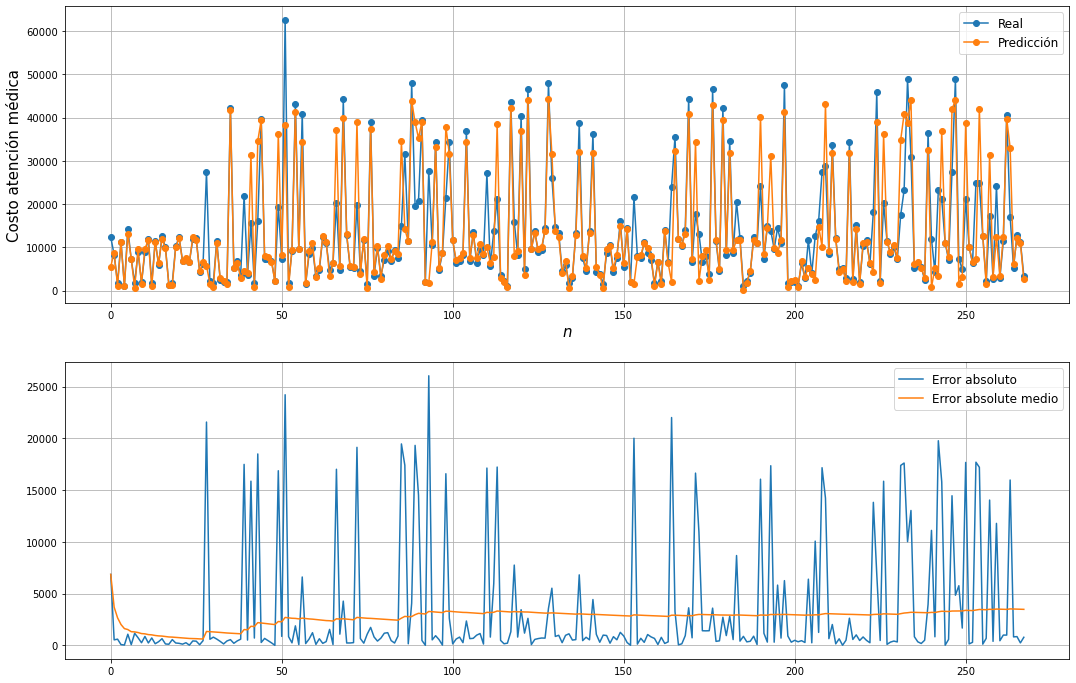

In [471]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    y_pred, 
    result_label='Costo atención médica'
)

## 4.2 Prueba #2
Esta es la prueba conceptual #2 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Step decay**

In [472]:
# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(df_x.shape[1],)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.StepDecay(10000, 0.5, 10))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=30,
    min_delta=5,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_step_decay.h5')

# Training the model
history = model.fit(
    x_train, y_train, validation_split=0.2, epochs=100, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback, 
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Epoch 1/100
14/14 - 2s - loss: 9860.3086 - val_loss: 13149.9570
Epoch 2/100
14/14 - 0s - loss: 11632.7910 - val_loss: 14602.8828
Epoch 3/100
14/14 - 0s - loss: 12984.6465 - val_loss: 9687.2441
Epoch 4/100
14/14 - 0s - loss: 11929.9385 - val_loss: 12134.6562
Epoch 5/100
14/14 - 0s - loss: 13048.6084 - val_loss: 7477.3037
Epoch 6/100
14/14 - 0s - loss: 12009.8115 - val_loss: 10993.3994
Epoch 7/100
14/14 - 0s - loss: 12973.9463 - val_loss: 12538.3467
Epoch 8/100
14/14 - 0s - loss: 12679.2344 - val_loss: 21210.5508
Epoch 9/100
14/14 - 0s - loss: 12934.1377 - val_loss: 8180.6401
Epoch 10/100
14/14 - 0s - loss: 11394.4072 - val_loss: 12400.3945
Epoch 11/100
14/14 - 0s - loss: 6351.3848 - val_loss: 8431.2725
Epoch 12/100
14/14 - 0s - loss: 5979.3936 - val_loss: 6426.4653
Epoch 13/100
14/14 - 0s - loss: 6471.6035 - val_loss: 3709.3428
Epoch 14/100
14/14 - 0s - loss: 6018.1523 - val_loss: 5183.7026
Epoch 15/100
14/14 - 0s - loss: 5796.5532 - val_loss: 4982.9697
Epoch 16/100
14/14 - 0s - loss: 6

In [473]:
# Load the best model saved
model = keras.models.load_model('linear_regression_step_decay.h5')

In [474]:
# Evaluate the model
train_mae = model.evaluate(x_train, y_train, verbose=0)
test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 3395.209716796875, Test: 3469.9130859375


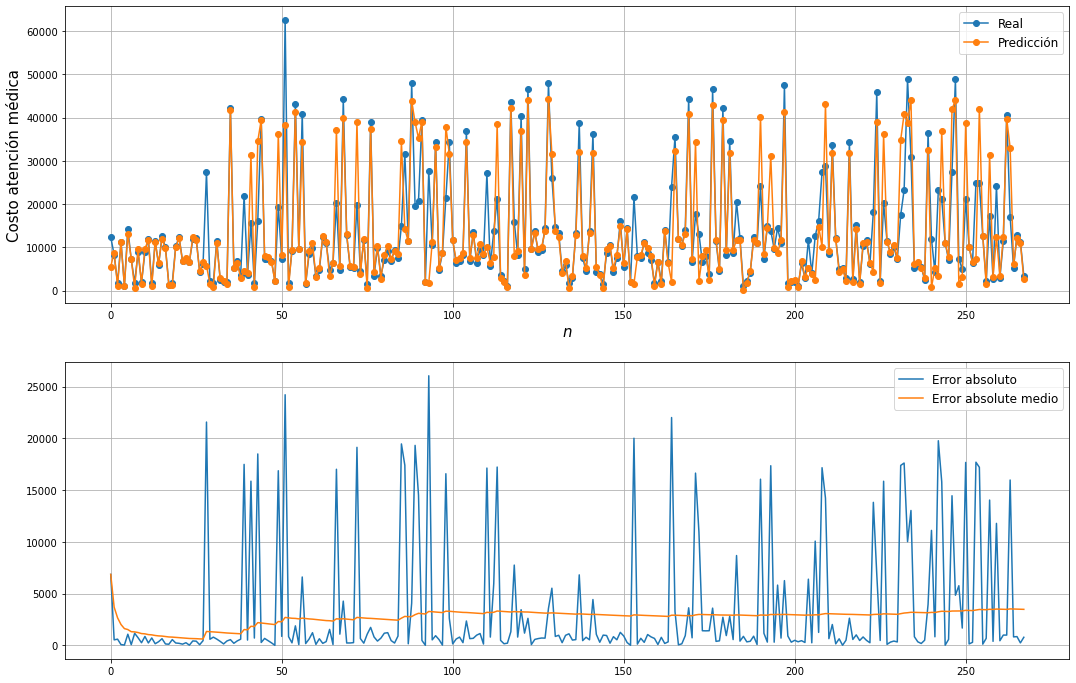

In [475]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    y_pred, 
    result_label='Costo atención médica'
)

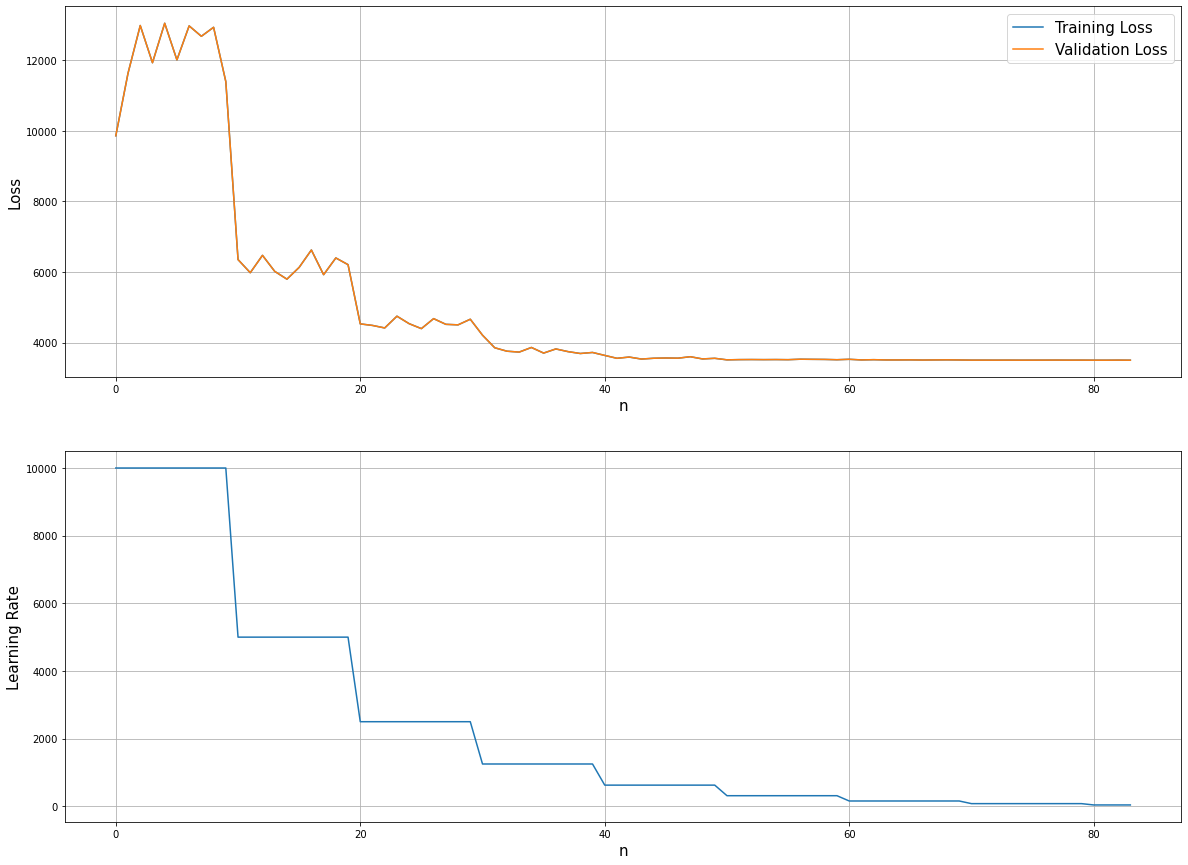

In [476]:
helper.plot_linear_regression_history(history)

## 4.3 Prueba #3
Esta es la prueba conceptual #2 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Exponential decay**

In [568]:
# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(df_x.shape[1],)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(10000, 0.07))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=30,
    min_delta=1,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_exponential_decay.h5')

# Training the model
history = model.fit(
    x_train, y_train, validation_split=0.2, epochs=100, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Epoch 1/100
14/14 - 3s - loss: 12213.0938 - val_loss: 4392.0361
Epoch 2/100
14/14 - 0s - loss: 10738.1670 - val_loss: 11425.7676
Epoch 3/100
14/14 - 0s - loss: 10565.4727 - val_loss: 7150.3218
Epoch 4/100
14/14 - 0s - loss: 9911.9102 - val_loss: 9699.6768
Epoch 5/100
14/14 - 0s - loss: 8088.9443 - val_loss: 7151.4399
Epoch 6/100
14/14 - 0s - loss: 7815.9111 - val_loss: 8173.7139
Epoch 7/100
14/14 - 0s - loss: 7653.7773 - val_loss: 7146.2671
Epoch 8/100
14/14 - 0s - loss: 6213.9634 - val_loss: 3706.8057
Epoch 9/100
14/14 - 0s - loss: 6277.7925 - val_loss: 6698.2847
Epoch 10/100
14/14 - 0s - loss: 5819.9189 - val_loss: 10171.1289
Epoch 11/100
14/14 - 0s - loss: 6169.4185 - val_loss: 7292.4854
Epoch 12/100
14/14 - 0s - loss: 5807.3926 - val_loss: 4034.2026
Epoch 13/100
14/14 - 0s - loss: 5438.7983 - val_loss: 5764.1060
Epoch 14/100
14/14 - 0s - loss: 5679.6396 - val_loss: 3821.8826
Epoch 15/100
14/14 - 0s - loss: 5338.5488 - val_loss: 4954.8862
Epoch 16/100
14/14 - 0s - loss: 5254.8105 - 

In [569]:
# Load the best model saved
model = keras.models.load_model('linear_regression_exponential_decay.h5')

In [570]:
# Evaluate the model
train_mae = model.evaluate(x_train, y_train, verbose=0)
test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 3395.27587890625, Test: 3463.439208984375


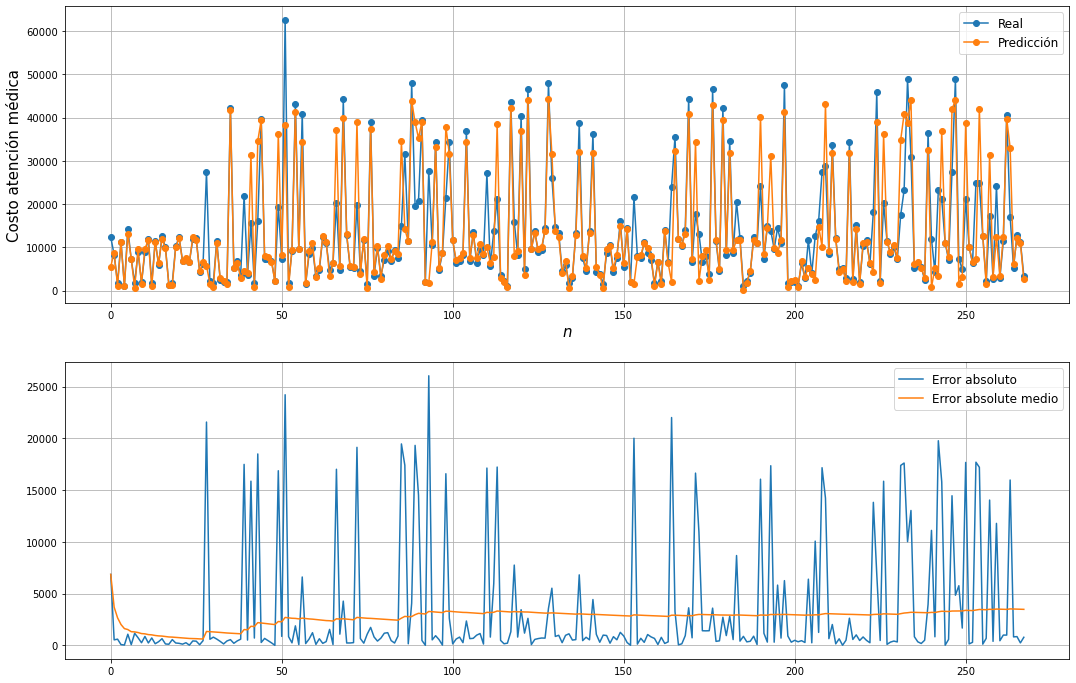

In [480]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    y_pred, 
    result_label='Costo atención médica'
)

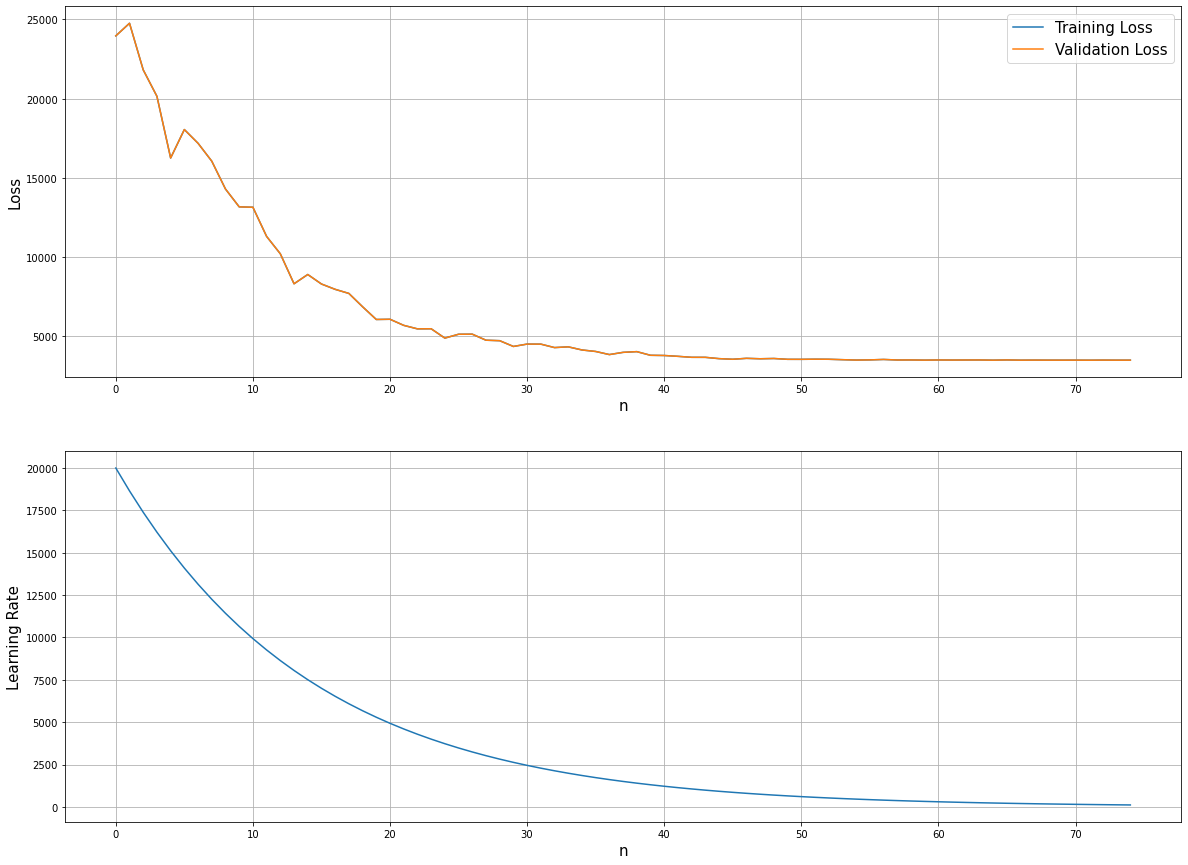

In [481]:
helper.plot_linear_regression_history(history)

## 4.4 Prueba #4
Esta es la prueba conceptual #4 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Exponential decay**
* Feature Engineering: **Polynomial Features 2° Degree**

In [543]:
# Creating the polynomial feature preprocessor
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(x_train)

# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(poly.n_output_features_,)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)
print(f'Using {len(model.get_weights()[0])} polynomial features counting the bias')

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(5000, 0.09))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=30,
    min_delta=10,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_polynomial_features_2.h5')

# Training the model
history = model.fit(
    poly.transform(x_train), y_train, validation_split=0.2, epochs=200, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Using 54 polynomial features counting the bias
Epoch 1/200
14/14 - 1s - loss: 27780.3008 - val_loss: 26022.5586
Epoch 2/200
14/14 - 0s - loss: 27660.3535 - val_loss: 26809.1328
Epoch 3/200
14/14 - 0s - loss: 26114.1406 - val_loss: 40143.4766
Epoch 4/200
14/14 - 0s - loss: 23017.5195 - val_loss: 21899.7266
Epoch 5/200
14/14 - 0s - loss: 22140.1758 - val_loss: 31401.3379
Epoch 6/200
14/14 - 0s - loss: 19127.7070 - val_loss: 32373.1504
Epoch 7/200
14/14 - 0s - loss: 16960.3789 - val_loss: 16263.8037
Epoch 8/200
14/14 - 0s - loss: 15784.6201 - val_loss: 9113.6270
Epoch 9/200
14/14 - 0s - loss: 13791.1973 - val_loss: 20798.3555
Epoch 10/200
14/14 - 0s - loss: 13713.1885 - val_loss: 25327.1289
Epoch 11/200
14/14 - 0s - loss: 12091.0371 - val_loss: 10001.1631
Epoch 12/200
14/14 - 0s - loss: 10577.8027 - val_loss: 12009.0215
Epoch 13/200
14/14 - 0s - loss: 9959.6865 - val_loss: 12833.4600
Epoch 14/200
14/14 - 0s - loss: 8659.7998 - val_loss: 12651.4346
Epoch 15/200
14/14 - 0s - loss: 9080.8887

In [544]:
# Load the best model saved
model = keras.models.load_model('linear_regression_polynomial_features_2.h5')

In [545]:
# Evaluate the model
train_mae = model.evaluate(poly.transform(x_train), y_train, verbose=0)
test_mae = model.evaluate(poly.transform(x_test), y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 1972.7315673828125, Test: 1991.0858154296875


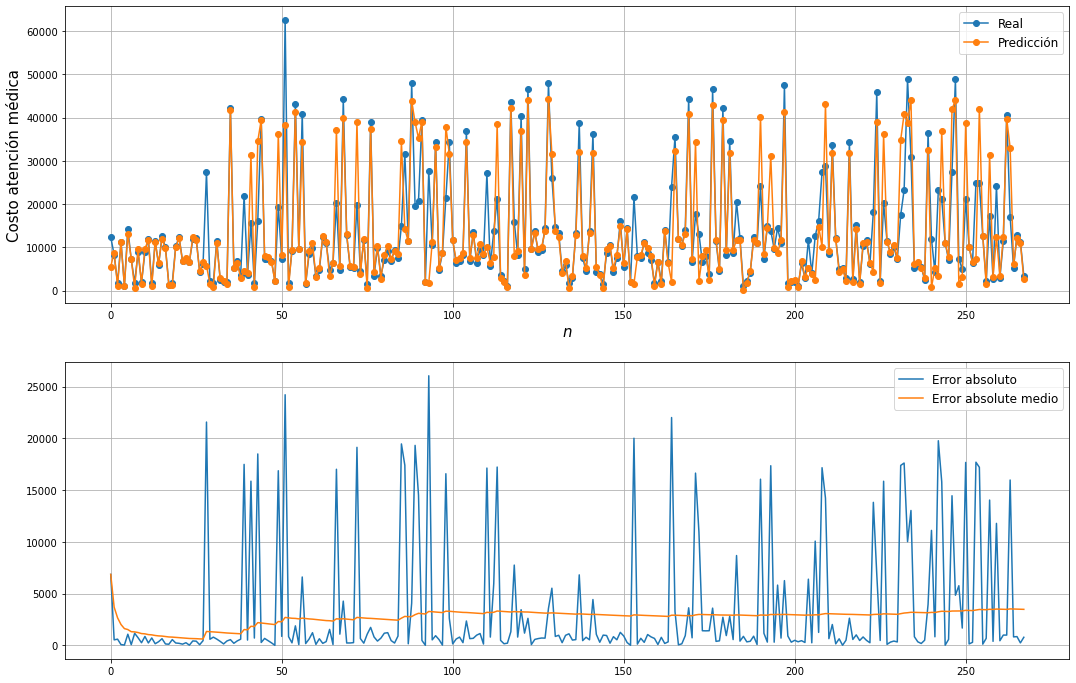

In [485]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    y_pred, 
    result_label='Costo atención médica'
)

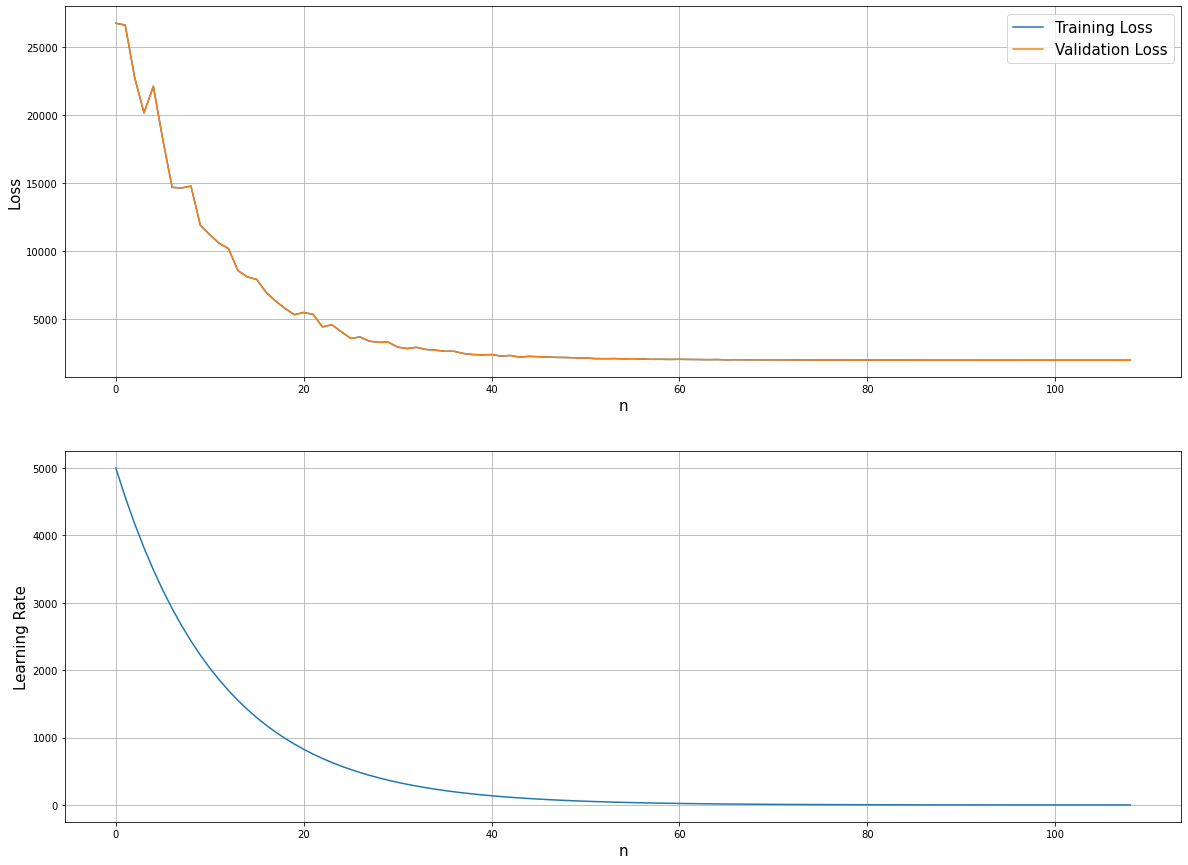

In [486]:
helper.plot_linear_regression_history(history)

## 4.5 Prueba #5
Esta es la prueba conceptual #5 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Exponential decay**
* Feature Engineering: **Polynomial Features 3° Degree**

In [487]:
# Creating the polynomial feature preprocessor
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(x_train)

# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(poly.n_output_features_,)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)
print(f'Using {len(model.get_weights()[0])} polynomial features counting the bias')

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(5000, 0.1))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    min_delta=10,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_polynomial_features_2.h5')

# Training the model
history = model.fit(
    poly.transform(x_train), y_train, validation_split=0.2, epochs=1000, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Using 219 polynomial features counting the bias
Epoch 1/1000
14/14 - 2s - loss: 177142.0000 - val_loss: 117642.3516
Epoch 2/1000
14/14 - 0s - loss: 144487.6094 - val_loss: 677451.4375
Epoch 3/1000
14/14 - 0s - loss: 165422.4531 - val_loss: 30507.4258
Epoch 4/1000
14/14 - 0s - loss: 127229.1484 - val_loss: 28862.9023
Epoch 5/1000
14/14 - 0s - loss: 123080.8672 - val_loss: 201362.7031
Epoch 6/1000
14/14 - 0s - loss: 97106.0000 - val_loss: 40412.8047
Epoch 7/1000
14/14 - 0s - loss: 83992.8438 - val_loss: 189164.1562
Epoch 8/1000
14/14 - 0s - loss: 87692.7266 - val_loss: 79398.3203
Epoch 9/1000
14/14 - 0s - loss: 80874.2266 - val_loss: 21940.2129
Epoch 10/1000
14/14 - 0s - loss: 64061.8086 - val_loss: 173652.4062
Epoch 11/1000
14/14 - 0s - loss: 67315.3203 - val_loss: 101981.2812
Epoch 12/1000
14/14 - 0s - loss: 62418.0039 - val_loss: 28398.6113
Epoch 13/1000
14/14 - 0s - loss: 43424.4062 - val_loss: 164651.5312
Epoch 14/1000
14/14 - 0s - loss: 54121.4961 - val_loss: 56391.0664
Epoch 15/10

In [488]:
# Load the best model saved
model = keras.models.load_model('linear_regression_polynomial_features_2.h5')

In [489]:
# Evaluate the model
train_mae = model.evaluate(poly.transform(x_train), y_train, verbose=0)
test_mae = model.evaluate(poly.transform(x_test), y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 2460.51806640625, Test: 2718.91455078125


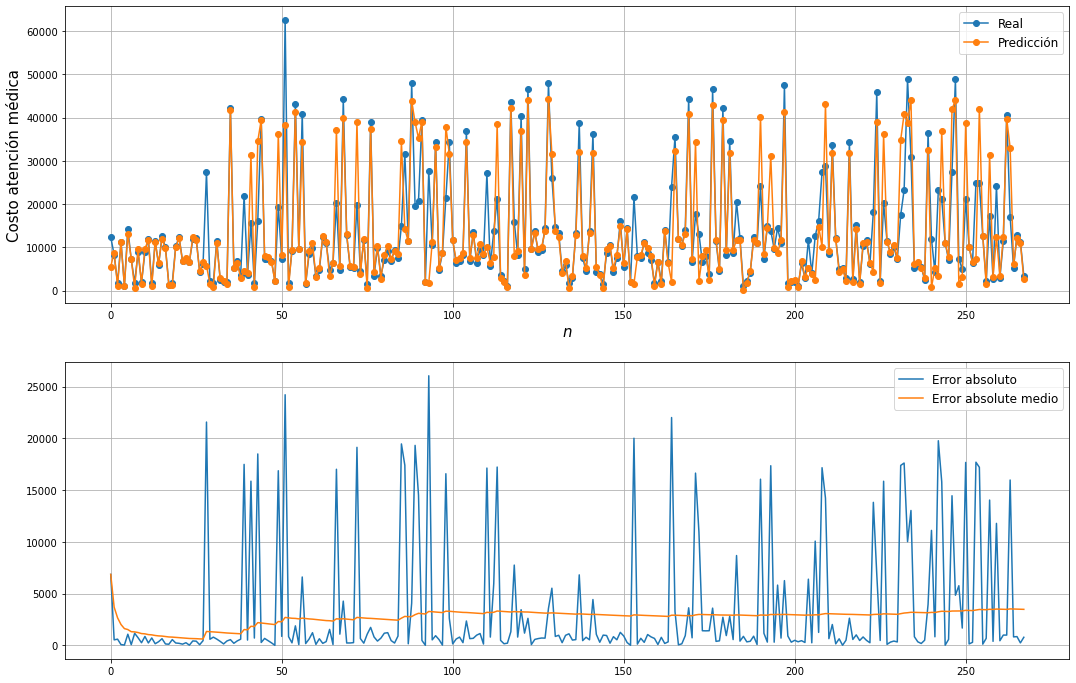

In [490]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    y_pred, 
    result_label='Costo atención médica'
)

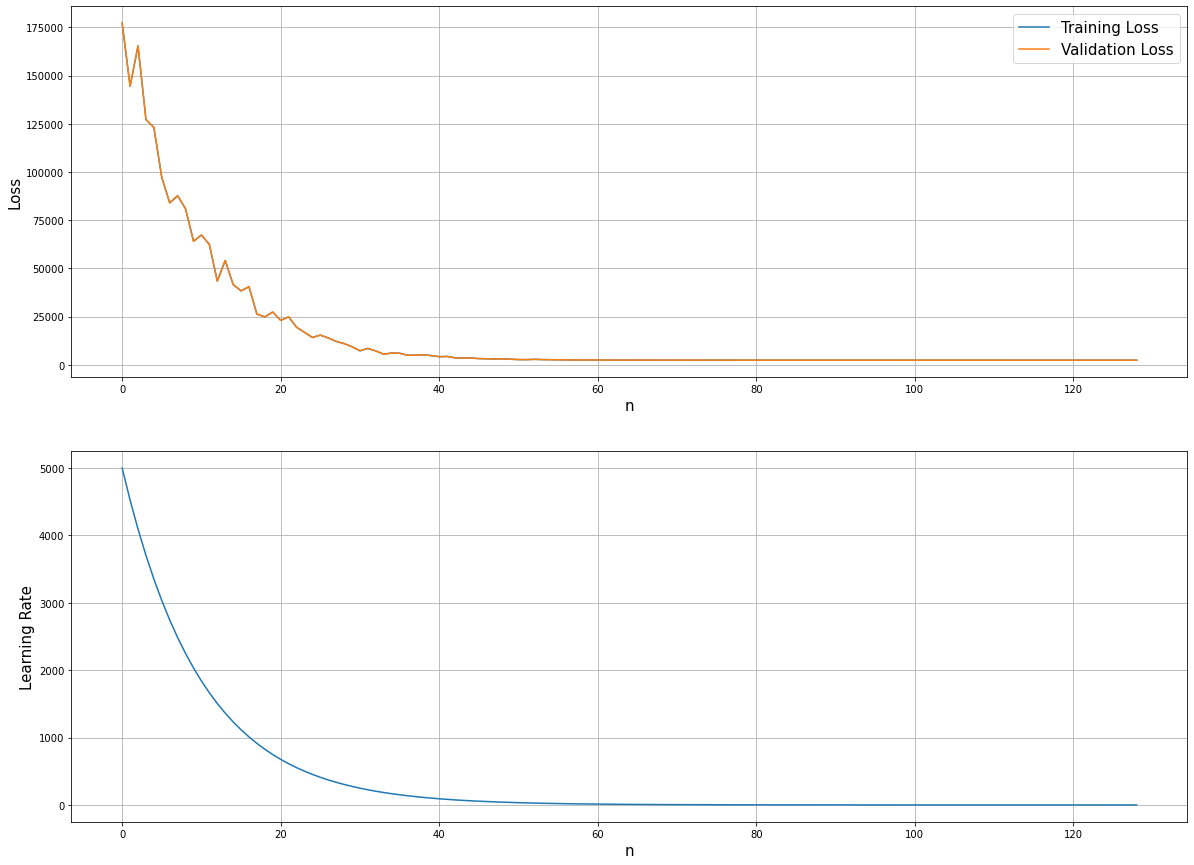

In [491]:
helper.plot_linear_regression_history(history)

## 4.5 Prueba #6
Esta es la prueba conceptual #6 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Exponential decay**
* Feature Engineering: **Polynomial Features 4° Degree**

In [492]:
# Creating the polynomial feature preprocessor
poly = preprocessing.PolynomialFeatures(degree=4, include_bias=False)
poly.fit(x_train)

# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(poly.n_output_features_,)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)
print(f'Using {len(model.get_weights()[0])} polynomial features counting the bias')

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(1000, 0.1))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    min_delta=10,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_polynomial_features_2.h5')

# Training the model
history = model.fit(
    poly.transform(x_train), y_train, validation_split=0.2, epochs=1000, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Using 714 polynomial features counting the bias
Epoch 1/1000
14/14 - 1s - loss: 279703.3750 - val_loss: 366543.8125
Epoch 2/1000
14/14 - 0s - loss: 342785.9375 - val_loss: 288163.7500
Epoch 3/1000
14/14 - 0s - loss: 249479.9844 - val_loss: 259039.6562
Epoch 4/1000
14/14 - 0s - loss: 243494.3594 - val_loss: 750086.5000
Epoch 5/1000
14/14 - 0s - loss: 243235.7031 - val_loss: 140027.2656
Epoch 6/1000
14/14 - 0s - loss: 156039.7500 - val_loss: 85926.3281
Epoch 7/1000
14/14 - 0s - loss: 184543.2969 - val_loss: 84199.5703
Epoch 8/1000
14/14 - 0s - loss: 192273.6250 - val_loss: 199653.2031
Epoch 9/1000
14/14 - 0s - loss: 122652.5234 - val_loss: 142265.7969
Epoch 10/1000
14/14 - 0s - loss: 150144.0312 - val_loss: 279185.7812
Epoch 11/1000
14/14 - 0s - loss: 140160.0781 - val_loss: 38317.3828
Epoch 12/1000
14/14 - 0s - loss: 118733.4844 - val_loss: 344459.0625
Epoch 13/1000
14/14 - 0s - loss: 126131.4922 - val_loss: 107186.7812
Epoch 14/1000
14/14 - 0s - loss: 105635.3906 - val_loss: 218817.046

In [493]:
# Load the best model saved
model = keras.models.load_model('linear_regression_polynomial_features_2.h5')

In [494]:
# Evaluate the model
train_mae = model.evaluate(poly.transform(x_train), y_train, verbose=0)
test_mae = model.evaluate(poly.transform(x_test), y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 3469.48291015625, Test: 4077.78125


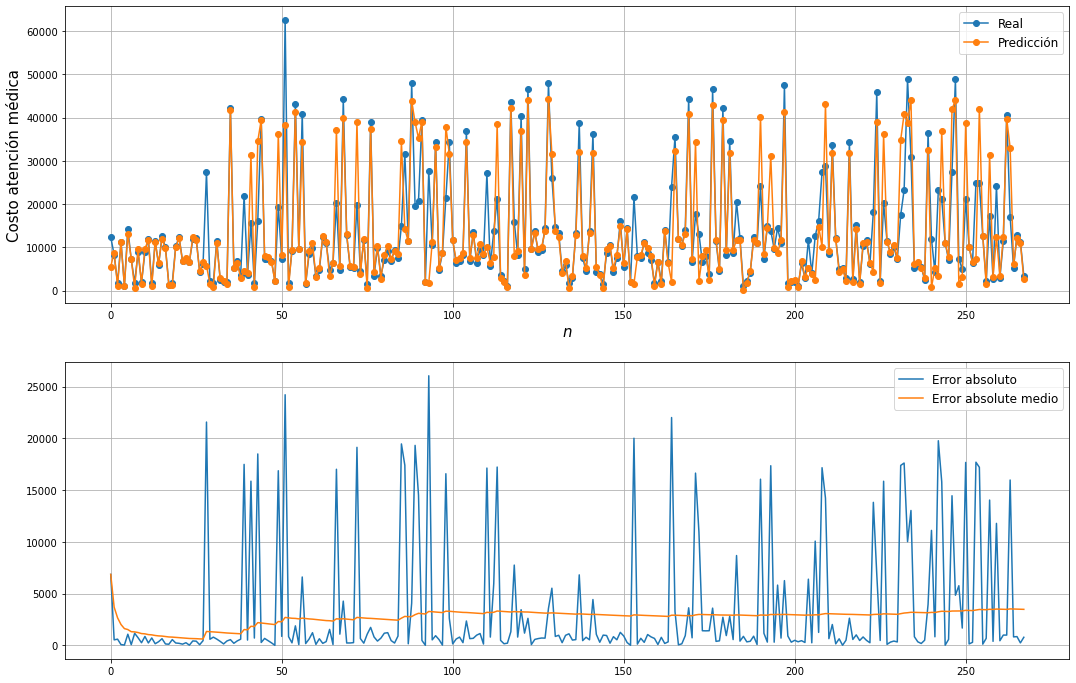

In [495]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    y_pred, 
    result_label='Costo atención médica'
)

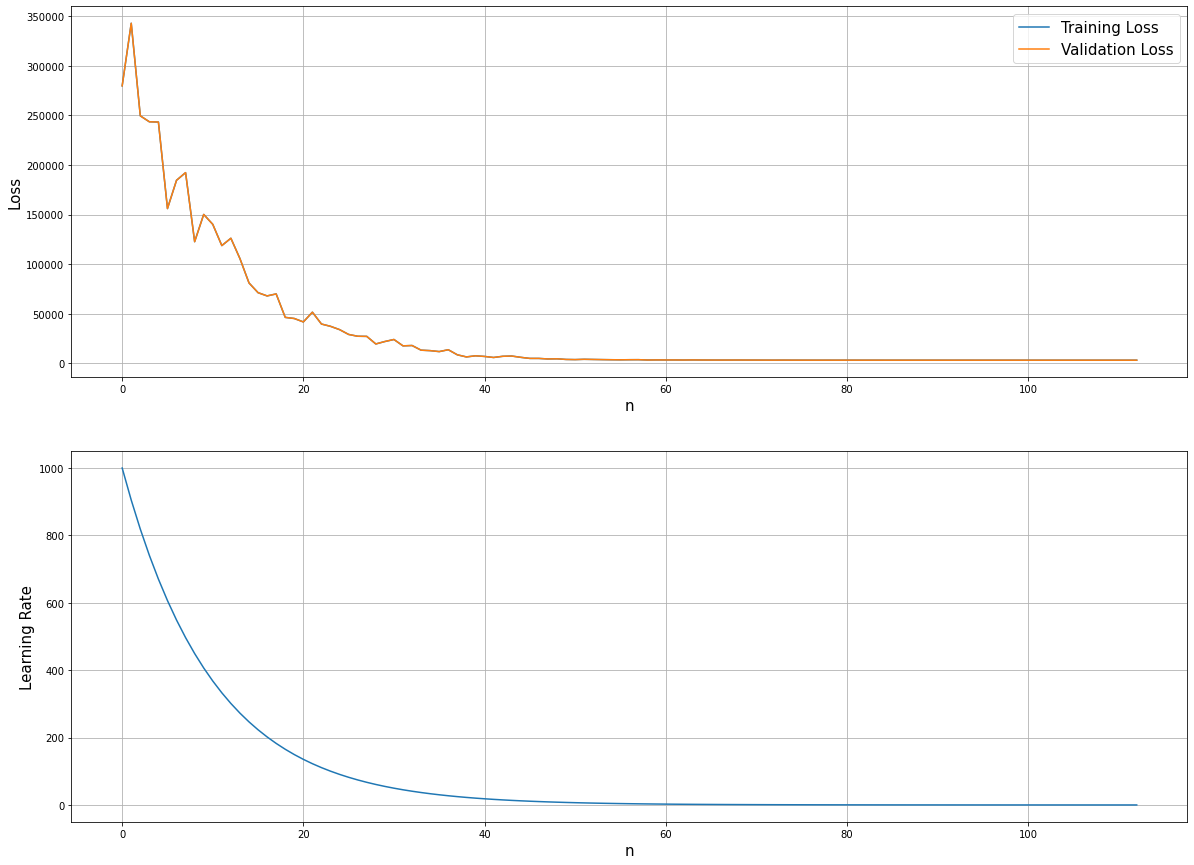

In [496]:
helper.plot_linear_regression_history(history)